In [1]:
# !/usr/env python3

'''
Output:
video captioning model itself and produce loss curve

Usage:
main document to train the video captioning model
'''

from __future__ import print_function
import tensorflow as tf
import pickle
import os
import numpy as np
import logging
import matplotlib.pyplot as plt
%matplotlib inline
from model.caption_model import sequence_2_sequence_LSTM


logging.basicConfig(level=logging.INFO)
#=======Change These===============================
tf.app.flags.DEFINE_string("model_name", "baseline_1", "name of the model")
tf.app.flags.DEFINE_integer("state_size", 100, "Size of each model layer.")
tf.app.flags.DEFINE_float("learning_rate", 0.001, "Base Learning rate.")
#==================================================

tf.app.flags.DEFINE_float("input_size", 7*7*512, "input size for each frame")
tf.app.flags.DEFINE_integer("batch_size", 64, "how many videos put per run")
tf.app.flags.DEFINE_integer("max_sentence_length", 4, "maximum captioning sentence length")
tf.app.flags.DEFINE_integer("word_vector_size", 50, "word embedding dimension default is 25 for twitter glove")
tf.app.flags.DEFINE_integer("n_epochs", 500, "number of epoch to run")
tf.app.flags.DEFINE_integer("num_frames", 15, "number of frames per video")
tf.app.flags.DEFINE_integer("hidden_size", 100, "output size of LSTM encoder and decoder")
tf.app.flags.DEFINE_float("dropout_rate", 0.5, "dropout probability for LSTM layers")
FLAGS = tf.app.flags.FLAGS        


def get_session():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    session = tf.Session(config=config)
    return session

if __name__ == '__main__':
    curPath = os.getcwd()
    dataPath = curPath + "/datasets/"

    # only pick first 100 for debugging purpose
    captions = pickle.load(open(dataPath+"id_captionInd_pairs.pickle", "rb"))[:100]
    print('captions shape: ', len(captions[0][1]))
    input_frames = np.random.randn(100, 15, 7*7*512)
    word_dict = pickle.load(open(dataPath + "word2Vector.pickle", "rb"))
    word_2_index = pickle.load(open(dataPath + 'word2index.pickle', 'rb'))

    wvector_dimension = 50
    word_embedding = np.zeros((len(word_dict), wvector_dimension))

    for word, w_vector in word_dict.items():
        if len(w_vector) != 0:
            word_index = word_2_index[word]
            word_embedding[word_index] = w_vector
    
    word_embedding = word_embedding.astype(np.float32)

    model = sequence_2_sequence_LSTM(word_embedding, FLAGS)
    model.build()

    with get_session() as sess:
        sess.run(tf.global_variables_initializer())
        losses, predict = model.train(sess, (input_frames, captions))

captions shape:  4
start building model ...
(?, 15, 25088)
caption embedding shape:  (?, 4, 50)
word vecs shape:  (?, 4, 50)
total number of parameter 10141050


100%|██████████| 500/500 [03:33<00:00,  2.40it/s]


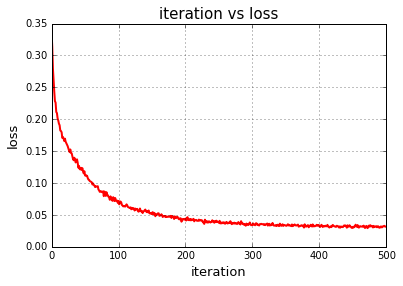

In [19]:
sample1 = predict[0]
sample1.shape

(4, 50)

In [15]:
sample2 = predict[10]

In [16]:
words = []
for i in range(4):
    best_error = float('inf')
    word_vec1 = sample2[i]
    for word, vec in word_dict.items():
        if len(vec) == 0:
            continue
        error = np.sum(np.square(word_vec1 - np.array(vec)))
        if error < best_error:
            word1 = word
            best_error = error
    words.append(word1)
words

['<START>', 'a', 'young', 'woman']